<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель будет предсказывать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Подготовка данных

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import kstest
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor


In [2]:
df_tr=pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_te=pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_all=pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
print(df_tr.info(),df_te.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


В данных есть определенные пропуски: в тренировочной информации более, чем в половине столбцов, а в тестовых данных - примерно в 20%. Однако заметим, что в тренировочных данных максимально пустой столбец лишился лишь 11% данных, а в тестовых максимально неполный столбец не имеет лишь 0.4% данных.

In [4]:
print(df_tr.head(),'_ \n'*7,df_te.head())

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [5]:
check_ef=(df_tr['rougher.output.concentrate_au']*(df_tr['rougher.input.feed_au']-df_tr['rougher.output.tail_au']))/(df_tr['rougher.input.feed_au']*(df_tr['rougher.output.concentrate_au']-df_tr['rougher.output.tail_au']))*100
print(check_ef.head(),df_tr['rougher.output.recovery'][:5],'\n_'*3)
print("Delta MAE:",mean_absolute_error(check_ef,df_tr['rougher.output.recovery']))


0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64 0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64 
_
_
_
Delta MAE: 9.73512347450521e-15


Ошибка мала - лишь 9.7 на 10 в -15 степени. Это крайне мало. Такая ошибка могла быть вызвана неточностями в подсчетах концентрата и ошибками при округлениях.

In [6]:
diff=set(df_tr.columns).difference(set(df_te.columns))
print(diff,'\n',len(diff))

{'primary_cleaner.output.tail_au', 'final.output.concentrate_pb', 'rougher.output.tail_sol', 'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_au', 'primary_cleaner.output.tail_sol', 'rougher.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'final.output.recovery', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.tail_ag', 'secondary_cleaner.output.tail_ag', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'primary_cleaner.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_ag', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_au', 'rougher.output.tail_pb', 'final.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'final.output.concentrate_sol', 'primary_cleaner.output.concentrate_pb', 'rougher.output.concentr

В тестовых данных нет 34 параметров - среди них почти все output, а также calculation.floatbank10_sulfate_to_au_feed, ougher.calculation.au_pb_ratio и rougher.calculation.floatbank11_sulfate_to_au_feed. Данные недоступны заранее, их невозможно предугадать, поэтому их стоит убрать, чтобы они не путали модель и чтобы не было утечки.

In [7]:
print(df_te[df_te['date'].duplicated()==True]['date'].count())
print(df_tr[df_tr['date'].duplicated()==True]['date'].count())

0
0


Нет явных дубликатов, отлично!

In [8]:
for i in [df_te,df_tr]:
    i=i.ffill(axis=0,inplace=True)

В задании была подсказка о том, что данные, полученные в одно время, похожи. Воспользуемся этим и заменим недостающие клетки данными из предыдущей клетки.

In [9]:
for i in [df_te,df_tr]:
    print(i[i.isna()==True].count())

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

## Анализ данных

In [10]:
df_au=df_all[['rougher.input.feed_au' ,'rougher.output.concentrate_au' ,'primary_cleaner.output.concentrate_au' ,'final.output.concentrate_au']]
df_pb=df_all[['rougher.input.feed_pb' ,'rougher.output.concentrate_pb' ,'primary_cleaner.output.concentrate_pb' ,'final.output.concentrate_pb']]
df_ag=df_all[['rougher.input.feed_ag' ,'rougher.output.concentrate_ag' ,'primary_cleaner.output.concentrate_ag' ,'final.output.concentrate_ag']]



print(df_au.head())

   rougher.input.feed_au  rougher.output.concentrate_au  \
0               6.486150                      19.793808   
1               6.478583                      20.050975   
2               6.362222                      19.737170   
3               6.118189                      19.320810   
4               5.663707                      19.216101   

   primary_cleaner.output.concentrate_au  final.output.concentrate_au  
0                              34.174427                    42.192020  
1                              34.118526                    42.701629  
2                              33.969464                    42.657501  
3                              28.260743                    42.689819  
4                              33.044932                    42.774141  


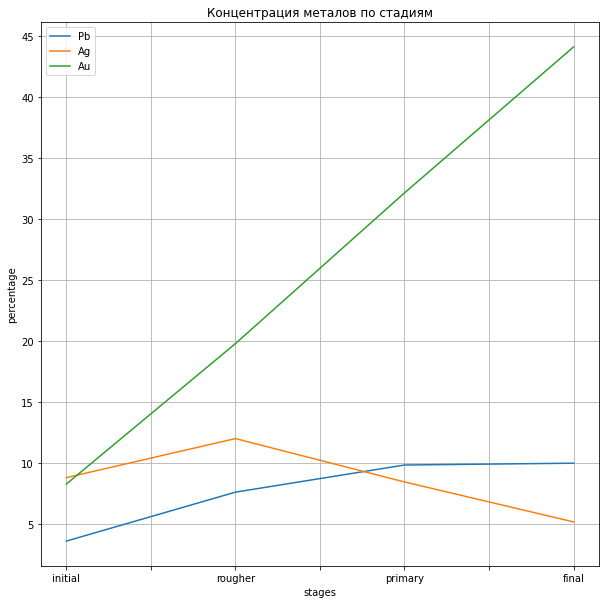

In [11]:
df_all_con=[df_pb,df_ag,df_au]
for i in df_all_con:
    i.columns=['initial','rougher','primary','final']
    i.mean().plot(figsize=(10,10),xlabel='stages',ylabel='percentage',title='Концентрация металов по стадиям',grid=True,legend=['pb','ag','au','sol'])
plt.legend(['Pb', 'Ag', 'Au'])

Видим, что концентрация золота увеличивается с 8% до 45%, а остальные концентрации остаются в пределах 10%. В этом и суть - получить максимум железа, минимизируя примеси.

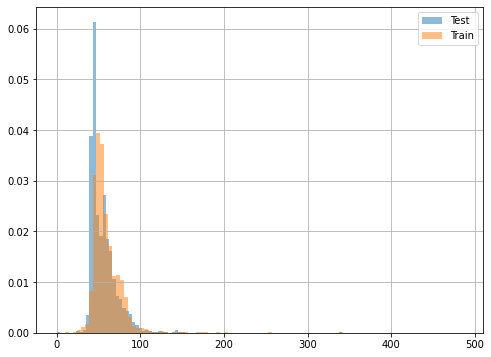

In [12]:

df_te['rougher.input.feed_size'].hist(alpha=0.5,bins=100,figsize=(8,6),density=True)
df_tr['rougher.input.feed_size'].hist(alpha=0.5,bins=100,figsize=(8,6),density=True)
plt.legend(['Test', 'Train'])

In [13]:
stat = ttest_ind(df_te['rougher.input.feed_size'], df_tr['rougher.input.feed_size'])
print(f"t-test: p-value={stat[1]}")


t-test: p-value=1.6081245670851643e-33


Нулевая гипотеза: в средних значениях отсутствуют различия. t-test показал значение p-value 1.6 на 10^-33 , что существенно меньше всех разумных уровней значимости, нулевая гипотеза **отвергнута**.

In [14]:
stat = kstest(df_te['rougher.input.feed_size'], df_tr['rougher.input.feed_size'])
print(f"Kolmogorov-Smirnov Test: p-value={stat[1]}")

Kolmogorov-Smirnov Test: p-value=5.1997046130555955e-213


Нулевая гипотеза: распределния одинаковы. Тест Колмогорова-Смирнова показал значение p-value 5.2 на 10^-213 , что существенно меньше всех разумных уровней значимости. Вывод: нулевая гипотеза об одинаковости распределений **отвергнута**.


Итог: данные распределены неодинаково.

0        51.680034
1        50.659114
2        50.609929
3        51.061546
4        47.859163
           ...    
19434    53.415050
19435    53.696482
19436    54.589604
19437    54.027355
19438    53.535054
Length: 19439, dtype: float64


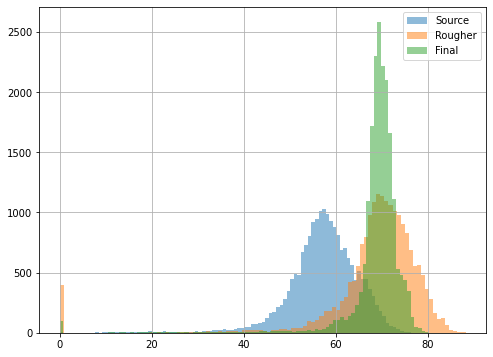

In [15]:
df_conc_source=df_all[['rougher.input.feed_au','rougher.input.feed_pb','rougher.input.feed_ag','rougher.input.feed_sol']].sum(axis=1)
df_conc_black=df_all[['rougher.output.concentrate_au','rougher.output.concentrate_pb','rougher.output.concentrate_ag','rougher.output.concentrate_sol']].sum(axis=1)
df_conc_final=df_all[['final.output.concentrate_au','final.output.concentrate_pb','final.output.concentrate_ag','final.output.concentrate_sol']].sum(axis=1)

df_conc_source.hist(alpha=0.5,bins=100,figsize=(8,6))
df_conc_black.hist(alpha=0.5,bins=100,figsize=(8,6))
df_conc_final.hist(alpha=0.5,bins=100,figsize=(8,6))
plt.legend(['Source', 'Rougher','Final'])
print(df_conc_source)

Можно заключить что грубая обработка убирает совсем бесполезные примеси, а вторичная уже увеличивает концентрацию золота. Видим аномалии: нулевые концентрации. Их следует удалить из данных.

In [16]:
#df_tr.drop(index=
df_tr=df_tr.drop(index=df_conc_black[df_conc_black==0].index,axis=0,errors='ignore')
df_tr=df_tr.drop(index=df_conc_final[df_conc_final==0].index,axis=0,errors='ignore')
print(df_tr.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13802 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                13802 non-null  object 
 1   final.output.concentrate_ag                         13802 non-null  float64
 2   final.output.concentrate_pb                         13802 non-null  float64
 3   final.output.concentrate_sol                        13802 non-null  float64
 4   final.output.concentrate_au                         13802 non-null  float64
 5   final.output.recovery                               13802 non-null  float64
 6   final.output.tail_ag                                13802 non-null  float64
 7   final.output.tail_pb                                13802 non-null  float64
 8   final.output.tail_sol                               13802 non-null  float64


## Модель

Зададим функции smape:

$$
SMAPE = \frac{1}{n} * \sum{\frac{|forecast - actual|}{(|actual|+|forecast|)\div{2}}}
$$

In [17]:
def smape(target, predicted):
    return 1/len(target) * np.sum(2 * np.abs(target - predicted) / (np.abs(target) + np.abs(predicted))*100)
def smape_final(rougher, final):
    return 0.25*rougher + 0.75*final

In [18]:
display(df_te.columns.shape,df_tr[df_te.columns].columns.shape)

(53,)

(53,)

In [19]:
subsets_common=['final.output.concentrate_ag',
                        'final.output.concentrate_au',
                        'final.output.concentrate_pb',
                        'final.output.concentrate_sol',
                        'final.output.tail_ag',
                        'final.output.tail_au',
                        'final.output.tail_pb',
                        'final.output.tail_sol',
                        'primary_cleaner.output.concentrate_ag',
                        'primary_cleaner.output.concentrate_au',
                        'primary_cleaner.output.concentrate_pb',
                        'primary_cleaner.output.concentrate_sol',
                        'primary_cleaner.output.tail_ag',
                        'primary_cleaner.output.tail_au',
                        'primary_cleaner.output.tail_pb',
                        'primary_cleaner.output.tail_sol',
                        'rougher.calculation.au_pb_ratio',
                        'rougher.calculation.floatbank10_sulfate_to_au_feed',
                        'rougher.calculation.floatbank11_sulfate_to_au_feed',
                        'rougher.calculation.sulfate_to_au_concentrate',
                        'rougher.output.concentrate_ag',
                        'rougher.output.concentrate_au',
                        'rougher.output.concentrate_pb',
                        'rougher.output.concentrate_sol',
                        'rougher.output.tail_ag',
                        'rougher.output.tail_au',
                        'rougher.output.tail_pb',
                        'rougher.output.tail_sol',
                        'secondary_cleaner.output.tail_ag',
                        'secondary_cleaner.output.tail_au',
                        'secondary_cleaner.output.tail_pb',
                        'secondary_cleaner.output.tail_sol']

In [20]:
df_tr=df_tr.drop(subsets_common,axis=1)

In [21]:
print(df_tr.info(),df_te.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13802 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13802 non-null  object 
 1   final.output.recovery                       13802 non-null  float64
 2   primary_cleaner.input.sulfate               13802 non-null  float64
 3   primary_cleaner.input.depressant            13802 non-null  float64
 4   primary_cleaner.input.feed_size             13802 non-null  float64
 5   primary_cleaner.input.xanthate              13802 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13802 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    13802 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      13802 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    13802 non-null  float64
 10  primary_cl

In [22]:
df_target = df_all[['date', 'rougher.output.recovery', 'final.output.recovery']]
df_te = df_te.merge(df_target, how = 'left', on = ['date'])
df_te.drop(['date'], axis=1, inplace=True)
df_tr.drop(['date'], axis=1, inplace=True)

#df_tr = df_tr.drop(set(df_tr.columns)-set(df_te.columns), axis=1)
print(df_te.info(),df_tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null   float64
 10  primary_clea

In [23]:
#subsets_common.append('rougher.output.recovery')
#subsets_common.append('final.output.recovery')
#print(subsets_common)

features_rougher_train = df_tr
features_rougher_train = features_rougher_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)

target_rougher_train = df_tr['rougher.output.recovery']


In [24]:
features_final_train = df_tr
features_final_train=features_final_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_final_train = df_tr['final.output.recovery']
# подготовим тестовые выборки
features_rougher_test = df_te
features_rougher_test = features_rougher_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_rougher_test = df_te['rougher.output.recovery']
features_final_test = df_te.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_final_test = df_te['final.output.recovery']

In [25]:
display(features_final_train.head(),features_final_test.head(),features_rougher_train.head(),features_rougher_test.head())


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [26]:
for i in [features_final_train,features_final_test,features_rougher_train,features_rougher_test,target_final_train,target_final_test,target_rougher_train,target_rougher_test]:
    print(i.shape)

(13802, 52)
(5290, 52)
(13802, 52)
(5290, 52)
(13802,)
(5290,)
(13802,)
(5290,)


In [27]:
print(features_rougher_train.info(),features_rougher_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13802 entries, 0 to 14148
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13802 non-null  float64
 1   primary_cleaner.input.depressant            13802 non-null  float64
 2   primary_cleaner.input.feed_size             13802 non-null  float64
 3   primary_cleaner.input.xanthate              13802 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13802 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13802 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13802 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13802 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13802 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    13802 non-null  float64
 10  primary_cl

Рассмотрим линейную регрессию и дерево решений, подобрав гиперпараметры.

In [28]:
model = LinearRegression()
scorer = make_scorer(smape, greater_is_better=False)
rougher_lin = cross_val_score(model, features_rougher_train, target_rougher_train, scoring=scorer, cv=5)
final_lin =  cross_val_score(model, features_final_train, target_final_train, scoring=scorer, cv=5)
print('Итоговое sMape для линейной регрессии:', smape_final(rougher_lin, final_lin).mean())

Итоговое sMape для линейной регрессии: -12.17135640815331


In [29]:
parametrs = {'max_depth': range (1,11, 1),
              'min_samples_leaf': range (1,11)}
scorer = make_scorer(smape, greater_is_better=False)
grid = GridSearchCV(DecisionTreeRegressor(random_state=12345), parametrs, cv=5,scoring=scorer)

grid.fit(features_rougher_train,target_rougher_train)
print('grid fitted successfully!') # это для отладки добавил. А то долго учится, мало ли я зря жду и всё давно крашнулось :-)

grid2=GridSearchCV(DecisionTreeRegressor(random_state=12345), parametrs, cv=5,scoring=scorer)

grid2.fit(features_final_train, target_final_train)

print('Лучший результат при параметрах',grid.best_params_,grid2.best_params_)

grid fitted successfully!
Лучший результат при параметрах {'max_depth': 6, 'min_samples_leaf': 6} {'max_depth': 2, 'min_samples_leaf': 1}


In [30]:
print(grid2.best_score_)
print(grid.best_score_)

-10.201944147611815
-10.805523607904803


Ошибка в Decision Tree меньше. Выбираем эту модель.

In [31]:
tmodel_rougher = DecisionTreeRegressor(random_state=12345, max_depth = 6,min_samples_leaf=6)
tmodel_final = DecisionTreeRegressor(random_state=12345, max_depth = 2,min_samples_leaf=1)
tmodel_rougher.fit(features_rougher_train, target_rougher_train)
tmodel_final.fit(features_final_train, target_final_train)
test_predictions_r = tmodel_rougher.predict(features_rougher_test)
test_predictions_f = tmodel_final.predict(features_final_test)
smape_f=smape(target_final_test,test_predictions_f)
smape_r=smape(target_rougher_test,test_predictions_r)

print('На тестовых данных sMAPE:',smape_final(smape_r,smape_f))


На тестовых данных sMAPE: 9.431424168327103


In [32]:
dummy=DummyRegressor(strategy='median')
dummy_r=dummy.fit(features_rougher_train,target_rougher_train)
dummy_f=dummy.fit(features_final_train,target_final_train)
dummy_predictions_r = dummy_r.predict(features_rougher_test)
dummy_predictions_f = dummy_f.predict(features_final_test)
smape_f=smape(target_final_test,dummy_predictions_f)
smape_r=smape(target_rougher_test,dummy_predictions_r)
print('На тестовых данных sMAPE:',smape_final(smape_r,smape_f))


На тестовых данных sMAPE: 14.462378580919562


**ВЫВОД**: выполнив работу, я выявил наиболее подходящую для прогноза модель и получил значение sMAPE на уровне 9. Модель рекомендуется к использованию, поскольку модель лучше, чем регрессор, предсказывающий медиану таргета.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке